In [1]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.collections import PatchCollection
from dask.distributed import Client, wait
from matplotlib.patches import Polygon
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import hex2color
from scipy.ndimage import gaussian_filter, binary_closing, binary_fill_holes
import matplotlib.ticker as ticker
import cartopy.feature as cfeature

### Open files

In [ ]:
file_path = Path("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/040_connectivity_analysis_05m/")

In [3]:
ds_conn_07 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_00-07days.nc"))

In [ ]:
ds_conn_14 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_07-14days.nc"))

In [5]:
ds_conn_28 = xr.open_dataset(str(file_path / "040_connectivity_analysis_05m_07-28days.nc"))

### Normalization

In [6]:
ds_conn_07["obs_per_origin_area"] = ds_conn_07.obs / ds_conn_07.water_fraction_hex0

In [7]:
ds_conn_14["obs_per_origin_area"] = ds_conn_14.obs / ds_conn_14.water_fraction_hex0

In [8]:
ds_conn_28["obs_per_origin_area"] = ds_conn_28.obs / ds_conn_28.water_fraction_hex0

### Labellig habitable zones
- depth < 85m, rest sites, aquaculture, historic sites, known disease sites, known healthy sites

In [9]:
ds_conn_07["habitable_hex0"] = (
    (ds_conn_07.depth_median_hex0 < 85)
    | (ds_conn_07.his_count_hex0 > 0)
    | (ds_conn_07.rst_count_hex0 > 0)
    | (ds_conn_07.aqc_count_hex0 > 0)
    | (ds_conn_07.dss_count_hex0 > 0)
    | (ds_conn_07.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_07["habitable_hex1"] = (
    (ds_conn_07.depth_median_hex1 < 85)
    | (ds_conn_07.rst_count_hex1 > 0)
    | (ds_conn_07.his_count_hex1 > 0)
    | (ds_conn_07.aqc_count_hex1 > 0)
    | (ds_conn_07.dss_count_hex1 > 0)
    | (ds_conn_07.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [10]:
ds_conn_14["habitable_hex0"] = (
    (ds_conn_14.depth_median_hex0 < 85)
    | (ds_conn_14.his_count_hex0 > 0)
    | (ds_conn_14.rst_count_hex0 > 0)
    | (ds_conn_14.aqc_count_hex0 > 0)
    | (ds_conn_14.dss_count_hex0 > 0)
    | (ds_conn_14.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_14["habitable_hex1"] = (
    (ds_conn_14.depth_median_hex1 < 85)
    | (ds_conn_14.rst_count_hex1 > 0)
    | (ds_conn_14.his_count_hex1 > 0)
    | (ds_conn_14.aqc_count_hex1 > 0)
    | (ds_conn_14.dss_count_hex1 > 0)
    | (ds_conn_14.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [11]:
ds_conn_28["habitable_hex0"] = (
    (ds_conn_28.depth_median_hex0 < 85)
    | (ds_conn_28.his_count_hex0 > 0)
    | (ds_conn_28.rst_count_hex0 > 0)
    | (ds_conn_28.aqc_count_hex0 > 0)
    | (ds_conn_28.dss_count_hex0 > 0)
    | (ds_conn_28.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_28["habitable_hex1"] = (
    (ds_conn_28.depth_median_hex1 < 85)
    | (ds_conn_28.rst_count_hex1 > 0)
    | (ds_conn_28.his_count_hex1 > 0)
    | (ds_conn_28.aqc_count_hex1 > 0)
    | (ds_conn_28.dss_count_hex1 > 0)
    | (ds_conn_28.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [12]:
habitable_to_habitable_01y_07 = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.habitable_hex0 > 0)
    & (ds_conn_07.habitable_hex1 > 0)
)

In [13]:
habitable_to_habitable_01y_14 = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.habitable_hex0 > 0)
    & (ds_conn_14.habitable_hex1 > 0)
)

In [14]:
habitable_to_habitable_01y_28 = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.habitable_hex0 > 0)
    & (ds_conn_28.habitable_hex1 > 0)
)

### Disease to habitable: Literature example (free Bonamia cells)

In [17]:
def plot_absolute_conc_single(ds_conn, timesteps, title, levels, colors, source_conc, fontsize=12, figsize=(6,6)):
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection': ccrs.Mercator()})

    # Build hex patches
    hex_patches = []
    for _lon, _lat in zip(ds_conn.lon_hex1_corners.data.T, ds_conn.lat_hex1_corners.data.T):
        ll = np.stack((_lon, _lat)).T
        hex_patches.append(Polygon(ll, closed=False))

    # Subset: only dss to habitable connections
    dss_to_habitable = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0).compute(), drop=True
    ).where(ds_conn.habitable_hex1 > 0)

    # Sum over all sources, months, years for each destination (hex1)
    Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])

    # Total number of particles released from all DSS sources
    N = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0), drop=True
    ).sum().item()

    # Relative concentration for each hex1
    rel_conc = Nobsh / (N * timesteps)

    # Absolute concentration at each hex1
    abs_conc = rel_conc * source_conc

    # Prepare array for plotting (log10, -9 for zeros)
    abs_conc_log = np.full(len(hex_patches), -9.0)
    hex1_indices = ds_conn.hex1.values if hasattr(ds_conn, "hex1") else np.arange(len(hex_patches))
    for j, hex1 in enumerate(hex1_indices):
        val = abs_conc.sel(hex1=hex1).item() if hex1 in abs_conc.hex1 else 0
        abs_conc_log[j] = np.log10(val) if val > 0 else -9

    # Plot
    p = PatchCollection(
        hex_patches, cmap=cmap, norm=norm, alpha=1.0, linewidth=0.1,
        transform=ccrs.PlateCarree(), zorder=0
    )
    p.set_array(abs_conc_log)
    ax.add_collection(p, autolim=True)

    # Land color
    ax.add_feature(cfeature.LAND, facecolor='#e6e6e6', zorder=-1)
    ax.coastlines(color='black', zorder=0)
    ax.set_extent([-11.2, 10, 46, 62.5])

    # Gridlines
    gl = ax.gridlines(draw_labels=True, zorder=0, alpha=0.2)
    gl.xlocator = ticker.MultipleLocator(3)
    gl.ylocator = ticker.MultipleLocator(3)
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(title, fontsize=fontsize)

    # Colorbar
    cbar = fig.colorbar(p, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(['0', '1e-1', '1e2', '1e4', '1e5'])  # adjust as needed
    cbar.set_label(r'$\it{Bonamia}$ cells / m$^{3}$ (log$_{10}$)', fontsize=fontsize)

    plt.tight_layout()
    plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\i'
<>:4: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2508972/1951003144.py:4: SyntaxWarning: invalid escape sequence '\i'
  title="Risk of $\it{Bonamia}$ dispersal",


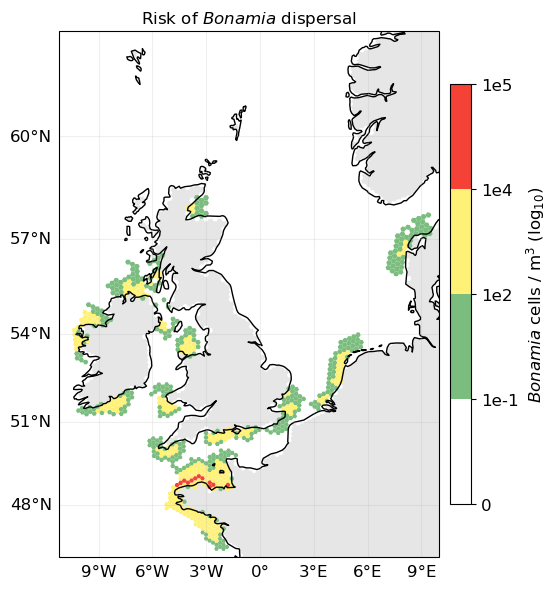

In [18]:
plot_absolute_conc_single(
    ds_conn_07,                
    timesteps=168,             
    title="Risk of $\it{Bonamia}$ dispersal",       
    levels=[-2, -1, 2, 4, 5],
    source_conc=1e8,
    colors=['#ffffff', '#7ABD7E', '#fff176', '#f44336'],
    fontsize=12
)

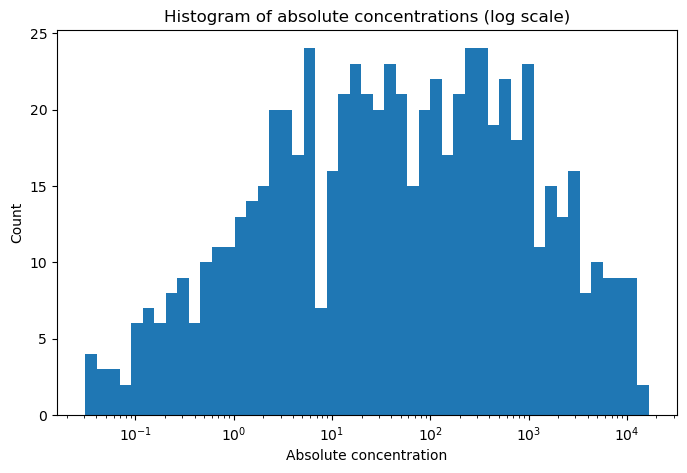

In [19]:
# Plot histogram of absolute concentrations to choose colorbar levels
source_conc = 1E8

# Calculate absolute concentrations for all hexes (flattened)
timesteps = 168  # adjust for your dataset (168 for 7-14 days, 504 for 07-28)
dss_to_habitable = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.dss_count_hex0 > 0).compute(), drop=True
).where(ds_conn_07.habitable_hex1 > 0)
Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])
N = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.dss_count_hex0 > 0), drop=True
).sum().item()
rel_conc = Nobsh / (N * timesteps)
abs_conc = rel_conc * source_conc

# Drop NaNs and flatten
abs_conc_flat = abs_conc.values.flatten()
abs_conc_flat = abs_conc_flat[~np.isnan(abs_conc_flat) & (abs_conc_flat > 0)]

plt.figure(figsize=(8, 5))
plt.hist(abs_conc_flat, bins=np.logspace(np.log10(abs_conc_flat.min()), np.log10(abs_conc_flat.max()), 50))
#plt.hist(abs_conc_flat, bins=50)
plt.xscale('log')
plt.xlabel('Absolute concentration')
plt.ylabel('Count')
plt.title('Histogram of absolute concentrations (log scale)')
plt.show()

### Disease to habitable: Literature example (infected larvae)

In [20]:
def plot_absolute_conc_single(ds_conn, timesteps, title, levels, colors, source_conc, fontsize=12, figsize=(6,6)):
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'projection': ccrs.Mercator()})

    # Build hex patches
    hex_patches = []
    for _lon, _lat in zip(ds_conn.lon_hex1_corners.data.T, ds_conn.lat_hex1_corners.data.T):
        ll = np.stack((_lon, _lat)).T
        hex_patches.append(Polygon(ll, closed=False))

    # Subset: only dss to habitable connections
    dss_to_habitable = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0).compute(), drop=True
    ).where(ds_conn.habitable_hex1 > 0)

    # Sum over all sources, months, years for each destination (hex1)
    Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])

    # Total number of particles released from all DSS sources
    N = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0), drop=True
    ).sum().item()

    # Relative concentration for each hex1
    rel_conc = Nobsh / (N * timesteps)

    # Absolute concentration at each hex1
    abs_conc = rel_conc * source_conc

    # Prepare array for plotting (log10, -9 for zeros)
    abs_conc_log = np.full(len(hex_patches), -9.0)
    hex1_indices = ds_conn.hex1.values if hasattr(ds_conn, "hex1") else np.arange(len(hex_patches))
    for j, hex1 in enumerate(hex1_indices):
        val = abs_conc.sel(hex1=hex1).item() if hex1 in abs_conc.hex1 else 0
        abs_conc_log[j] = np.log10(val) if val > 0 else -9

    # Plot
    p = PatchCollection(
        hex_patches, cmap=cmap, norm=norm, alpha=1.0, linewidth=0.1,
        transform=ccrs.PlateCarree(), zorder=0
    )
    p.set_array(abs_conc_log)
    ax.add_collection(p, autolim=True)

    # Land color
    ax.add_feature(cfeature.LAND, facecolor='#e6e6e6', zorder=-1)
    ax.coastlines(color='black', zorder=0)
    ax.set_extent([-11.2, 10, 46, 62.5])

    # Gridlines
    gl = ax.gridlines(draw_labels=True, zorder=0, alpha=0.2)
    gl.xlocator = ticker.MultipleLocator(3)
    gl.ylocator = ticker.MultipleLocator(3)
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    gl.top_labels = False
    gl.right_labels = False

    ax.set_title(title, fontsize=fontsize)

    # Colorbar
    cbar = fig.colorbar(p, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(['0','1e-4','1e0','1e1','1e2']) 
    cbar.set_label(r'larvae / m$^{3}$ (log$_{10}$)', fontsize=fontsize)

    plt.tight_layout()
    plt.show()

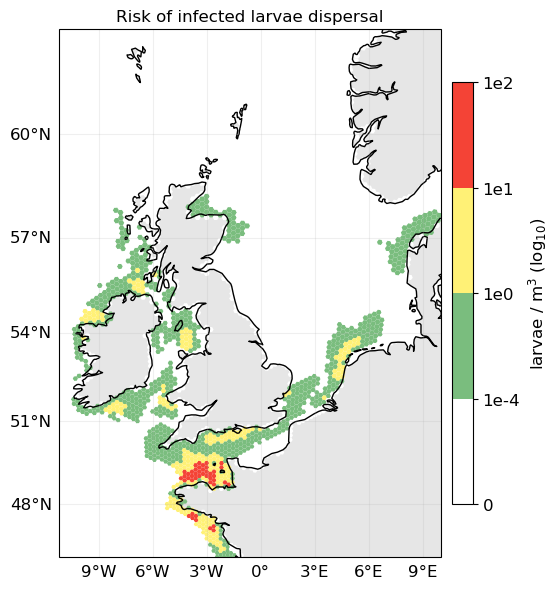

In [21]:
plot_absolute_conc_single(
    ds_conn_28,                
    timesteps=504,             
    title="Risk of infected larvae dispersal",       
    levels=[-4,-2,0,1,2],
    source_conc=1e6,
    colors=['#ffffff', '#7ABD7E', '#fff176', '#f44336'],
    fontsize=12
)

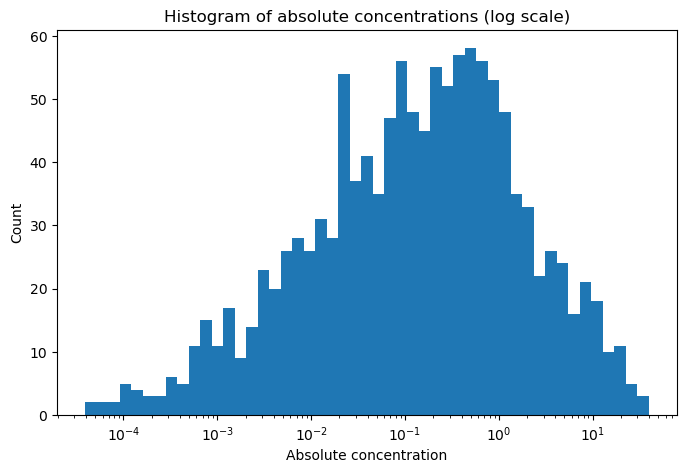

In [92]:
# Plot histogram of absolute concentrations to choose colorbar levels
source_conc = 1E6

# Calculate absolute concentrations for all hexes (flattened)
timesteps = 504  # adjust for your dataset (168 for 7-14 days, 504 for 07-28)
dss_to_habitable = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0).compute(), drop=True
).where(ds_conn_28.habitable_hex1 > 0)
Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])
N = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0), drop=True
).sum().item()
rel_conc = Nobsh / (N * timesteps)
abs_conc = rel_conc * source_conc

# Drop NaNs and flatten
abs_conc_flat = abs_conc.values.flatten()
abs_conc_flat = abs_conc_flat[~np.isnan(abs_conc_flat) & (abs_conc_flat > 0)]

plt.figure(figsize=(8, 5))
plt.hist(abs_conc_flat, bins=np.logspace(np.log10(abs_conc_flat.min()), np.log10(abs_conc_flat.max()), 50))
plt.xscale('log')
plt.xlabel('Absolute concentration')
plt.ylabel('Count')
plt.title('Histogram of absolute concentrations (log scale)')
plt.show()

### including 95% interval

In [17]:
def plot_fraction_arrived_side_by_side(ds_list, timesteps_list, titles, levels, colors, fontsize=12, figsize=(15,6)):
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.03], wspace=0.05)
    axes = [fig.add_subplot(gs[0, i], projection=ccrs.Mercator()) for i in range(3)]
    patch_artist = None

    for i, (ds_conn, timesteps, ax, title) in enumerate(zip(ds_list, timesteps_list, axes, titles)):
        # Build hex patches
        hex_patches = []
        for _lon, _lat in zip(ds_conn.lon_hex1_corners.data.T, ds_conn.lat_hex1_corners.data.T):
            ll = np.stack((_lon, _lat)).T
            hex_patches.append(Polygon(ll, closed=False))

        # Subset: only dss to habitable connections
        dss_to_habitable = ds_conn.obs_per_origin_area.where(
            (ds_conn.dss_count_hex0 > 0).compute(), drop=True
        ).where(ds_conn.habitable_hex1 > 0)

        # Sum over all sources, months, years for each destination (hex1)
        Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])

        # Total number of particles released from all DSS sources
        N = ds_conn.obs_per_origin_area.where(
            (ds_conn.dss_count_hex0 > 0), drop=True
        ).sum().item()

        # Absolute fraction for each hex1
        fraction_arrived = Nobsh / (N * timesteps)

        # Prepare array for plotting (log10, -9 for zeros)
        fraction_arrived_log = np.full(len(hex_patches), -9.0)
        hex1_indices = ds_conn.hex1.values if hasattr(ds_conn, "hex1") else np.arange(len(hex_patches))
        for j, hex1 in enumerate(hex1_indices):
            val = fraction_arrived.sel(hex1=hex1).item() if hex1 in fraction_arrived.hex1 else 0
            fraction_arrived_log[j] = np.log10(val) if val > 0 else -9
                # --- 95% density region contour ---
        # 1. Get values for all hexes
        fraction_arrived_vals = np.array([
            fraction_arrived.sel(hex1=hex1).item() if hex1 in fraction_arrived.hex1 else 0
            for hex1 in hex1_indices
        ])
        # 2. Sort indices by value descending
        sorted_idx = np.argsort(fraction_arrived_vals)[::-1]
        sorted_vals = fraction_arrived_vals[sorted_idx]
        # 3. Cumulative sum and mask for 95%
        cumsum = np.cumsum(sorted_vals)
        total = cumsum[-1]
        cutoff = 0.95 * total
        mask_95 = np.zeros_like(fraction_arrived_vals, dtype=bool)
        mask_95[sorted_idx[:np.searchsorted(cumsum, cutoff) + 1]] = True
        
        # Get lon/lat centroids for each hex
        lons = np.array([np.mean(ds_conn.lon_hex1_corners.data[:, j]) for j in range(len(hex_patches))])
        lats = np.array([np.mean(ds_conn.lat_hex1_corners.data[:, j]) for j in range(len(hex_patches))])

        # 1. Rasterize the mask to a grid (coarser grid helps connect regions)
        lon_bins = np.linspace(lons.min(), lons.max(), 250) # the more bins the finer
        lat_bins = np.linspace(lats.min(), lats.max(), 250)
        grid, _, _ = np.histogram2d(lats[mask_95], lons[mask_95], bins=[lat_bins, lon_bins])

# 2. Convert to boolean mask (any bin with count > 0)
        mask_grid = grid > 0

# 3. Morphological closing to connect adjacent bins (fills small gaps)
        mask_closed = binary_closing(mask_grid, structure=np.ones((3, 3)))

# 4. Fill holes inside the region
        mask_filled = binary_fill_holes(mask_closed)

# 5. Optionally smooth the mask for a smoother outline
        mask_smooth = gaussian_filter(mask_filled.astype(float), sigma=0) # adjust sigma for smoothing

# 6. Use bin centers for meshgrid
        lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
        lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
        X, Y = np.meshgrid(lon_centers, lat_centers)

# 7. Draw the contour at level 0.5 (boundary of the filled region)
        ax.contour(X, Y, mask_smooth, levels=[0.5], colors='cyan', linewidths=1.2, transform=ccrs.PlateCarree(), zorder=20)
        
        # Plot
        p = PatchCollection(
            hex_patches, cmap=cmap, norm=norm, alpha=1.0, linewidth=0.1,
            transform=ccrs.PlateCarree(), zorder=0
        )
        p.set_array(fraction_arrived_log)
        ax.add_collection(p, autolim=True)

        # Land color
        ax.add_feature(cfeature.LAND, facecolor='#e6e6e6', zorder=-1)
        ax.coastlines(color='black', zorder=0)
        ax.set_extent([-11.2, 10, 46, 62.5])

        # Gridlines
        gl = ax.gridlines(draw_labels=True, zorder=0, alpha=0.2)
        gl.xlocator = ticker.MultipleLocator(3)
        gl.ylocator = ticker.MultipleLocator(3)
        gl.xlabel_style = {'size': fontsize}
        gl.ylabel_style = {'size': fontsize}
        gl.top_labels = False
        gl.right_labels = False

        # Only leftmost plot gets y-tick labels
        if i == 0:
            gl.left_labels = True
            gl.bottom_labels = True
        else:
            gl.left_labels = False
            gl.bottom_labels = True
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.yaxis.set_ticks_position('none')
            ax.tick_params(axis='y', which='both', length=0, labelleft=False)

        ax.set_title(title, fontsize=fontsize)
        patch_artist = p  # for colorbar

    # Shared colorbar
    cbar_ax = fig.add_axes([0.88, 0.25, 0.015, 0.5])
    cbar = fig.colorbar(patch_artist, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3'])
    cbar.set_label('Relative concentration (log10)', fontsize=fontsize)

    fig.subplots_adjust(left=0.22, right=0.86, wspace=0.05)
    fig.tight_layout()
    plt.show()

/tmp/ipykernel_2551675/3749599364.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


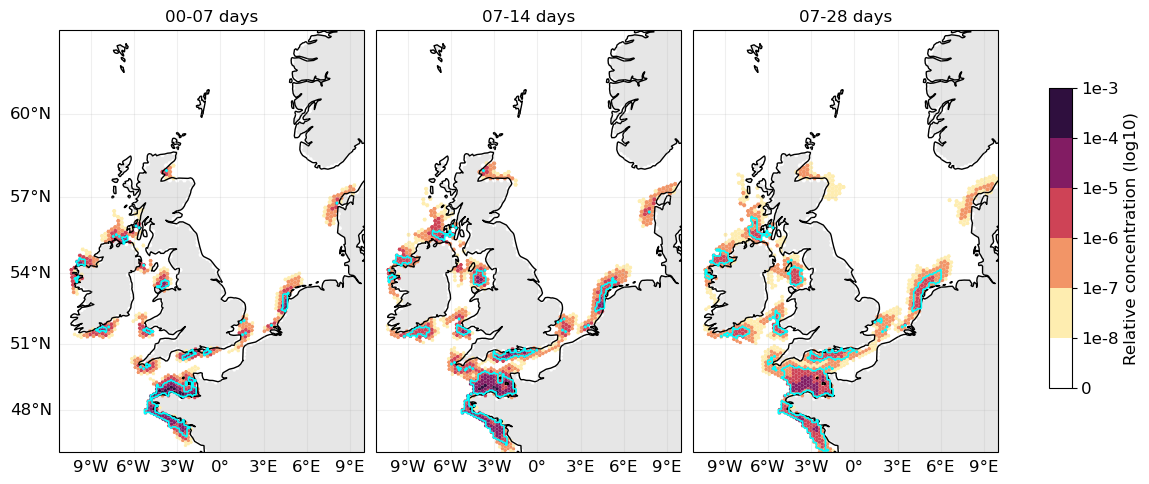

In [18]:
ds_list = [ds_conn_07, ds_conn_14, ds_conn_28]
timesteps_list = [168, 168, 504]
titles = ["00-07 days", "07-14 days", "07-28 days"]
levels = [-9, -8, -7, -6, -5, -4, -3]
fontsize = 12
colors = ['#ffffff', '#feedb0', '#f29567', '#ce4356', '#821c63', '#2f0f3e']

plot_fraction_arrived_side_by_side(ds_list, timesteps_list, titles, levels, colors, fontsize)


### subset to check if number of particles was enough

/tmp/ipykernel_684926/3749599364.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


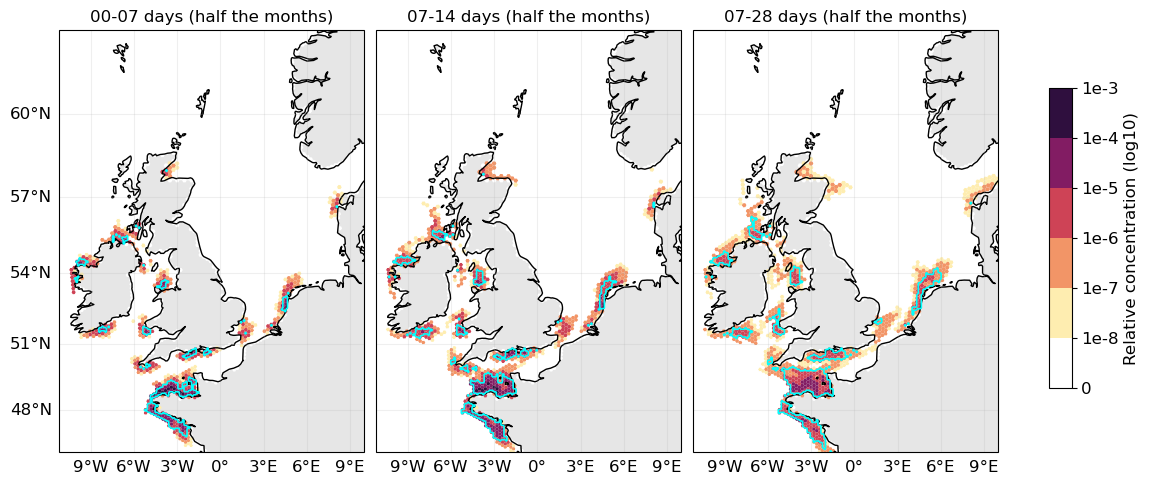

: 

In [ ]:
# --- Subset to half the months and half the years, then plot ---

def subset_half_months_years(ds):
    # Take first half of months and years
    months = ds.month.values
    years = ds.year.values
    half_months = months[:len(months)//2] if len(months) > 1 else months
    half_years = years[:len(years)//2] if len(years) > 1 else years
    return ds.sel(month=half_months, year=half_years)

# Subsampled datasets
ds_conn_07_half = subset_half_months_years(ds_conn_07)
ds_conn_14_half = subset_half_months_years(ds_conn_14)
ds_conn_28_half = subset_half_months_years(ds_conn_28)

# Use the same plotting parameters as before
ds_list_half = [ds_conn_07_half, ds_conn_14_half, ds_conn_28_half]
timesteps_list = [168, 168, 504]
titles = ["00-07 days (half the months)", "07-14 days (half the months)", "07-28 days (half the months)"]
levels = [-9, -8, -7, -6, -5, -4, -3]
fontsize = 12
colors = ['#ffffff', '#feedb0', '#f29567', '#ce4356', '#821c63', '#2f0f3e']

plot_fraction_arrived_side_by_side(ds_list_half, timesteps_list, titles, levels, colors, fontsize)


In [16]:
#50% particles

def randomly_mask_obs(ds, fraction=0.5, seed=42):
    rng = np.random.default_rng(seed)
    mask = xr.DataArray(
        rng.random(ds.obs_per_origin_area.shape) < fraction,
        dims=ds.obs_per_origin_area.dims,
        coords=ds.obs_per_origin_area.coords
    )
    ds_masked = ds.copy()
    ds_masked["obs_per_origin_area"] = ds.obs_per_origin_area.where(mask, 0)
    return ds_masked

ds_conn_07_50prct = randomly_mask_obs(ds_conn_07, fraction=0.5)
ds_conn_14_50prct = randomly_mask_obs(ds_conn_14, fraction=0.5)
ds_conn_28_50prct = randomly_mask_obs(ds_conn_28, fraction=0.5)

ds_list_50prct = [ds_conn_07_50prct, ds_conn_14_50prct, ds_conn_28_50prct]
titles = ["00-07 days (50%)", "07-14 days (50%)", "07-28 days (50%)"]
timesteps_list = [168, 168, 504]
levels = [-9, -8, -7, -6, -5, -4, -3]
fontsize = 12
colors = ['#ffffff', '#feedb0', '#f29567', '#ce4356', '#821c63', '#2f0f3e']
plot_fraction_arrived_side_by_side(ds_list_50prct, timesteps_list, titles, levels, colors, fontsize)

: 

: 

/tmp/ipykernel_32123/640928735.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


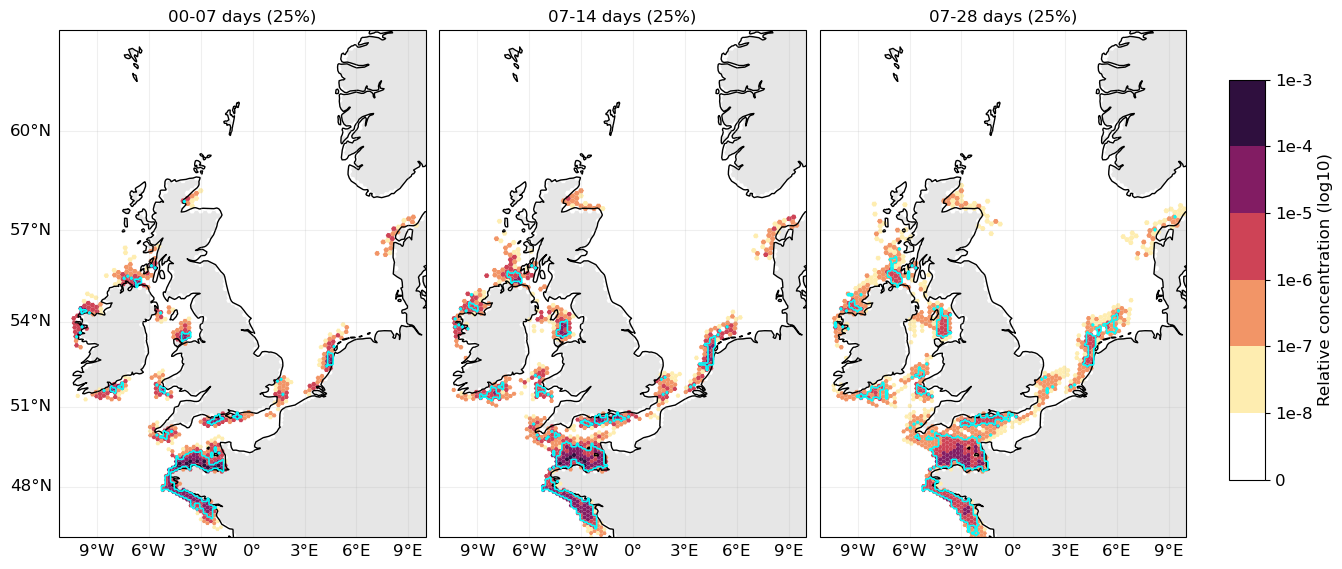

In [ ]:
#25% particles

def randomly_mask_obs(ds, fraction=0.25, seed=42):
    rng = np.random.default_rng(seed)
    mask = xr.DataArray(
        rng.random(ds.obs_per_origin_area.shape) < fraction,
        dims=ds.obs_per_origin_area.dims,
        coords=ds.obs_per_origin_area.coords
    )
    ds_masked = ds.copy()
    ds_masked["obs_per_origin_area"] = ds.obs_per_origin_area.where(mask, 0)
    return ds_masked

ds_conn_07_25prct = randomly_mask_obs(ds_conn_07, fraction=0.25)
ds_conn_14_25prct = randomly_mask_obs(ds_conn_14, fraction=0.25)
ds_conn_28_25prct = randomly_mask_obs(ds_conn_28, fraction=0.25)

ds_list_25prct = [ds_conn_07_25prct, ds_conn_14_25prct, ds_conn_28_25prct]
titles = ["00-07 days (25%)", "07-14 days (25%)", "07-28 days (25%)"]
timesteps_list = [168, 168, 504]
levels = [-9, -8, -7, -6, -5, -4, -3]
fontsize = 12
colors = ['#ffffff', '#feedb0', '#f29567', '#ce4356', '#821c63', '#2f0f3e']
plot_fraction_arrived_side_by_side(ds_list_25prct, timesteps_list, titles, levels, colors, fontsize)

/tmp/ipykernel_31057/640928735.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


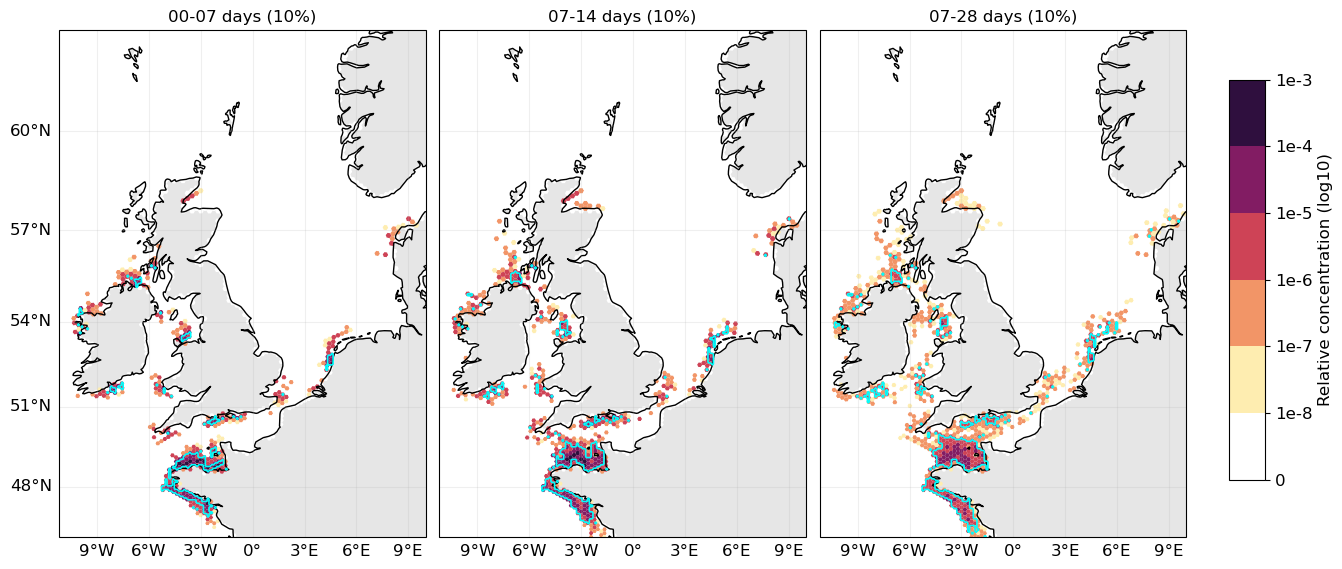

In [ ]:
#10% particles

def randomly_mask_obs(ds, fraction=0.1, seed=42):
    # fraction: fraction of obs to keep (e.g. 0.1 for 10%)
    rng = np.random.default_rng(seed)
    mask = xr.DataArray(
        rng.random(ds.obs_per_origin_area.shape) < fraction,
        dims=ds.obs_per_origin_area.dims,
        coords=ds.obs_per_origin_area.coords
    )
    ds_masked = ds.copy()
    ds_masked["obs_per_origin_area"] = ds.obs_per_origin_area.where(mask, 0)
    return ds_masked

ds_conn_07_10prct = randomly_mask_obs(ds_conn_07, fraction=0.1)
ds_conn_14_10prct = randomly_mask_obs(ds_conn_14, fraction=0.1)
ds_conn_28_10prct = randomly_mask_obs(ds_conn_28, fraction=0.1)

ds_list_10prct = [ds_conn_07_10prct, ds_conn_14_10prct, ds_conn_28_10prct]
titles = ["00-07 days (10%)", "07-14 days (10%)", "07-28 days (10%)"]
plot_fraction_arrived_side_by_side(ds_list_10prct, timesteps_list, titles, levels, colors, fontsize)

### 1 Year: Disease to habitable AVERAGE 07-14

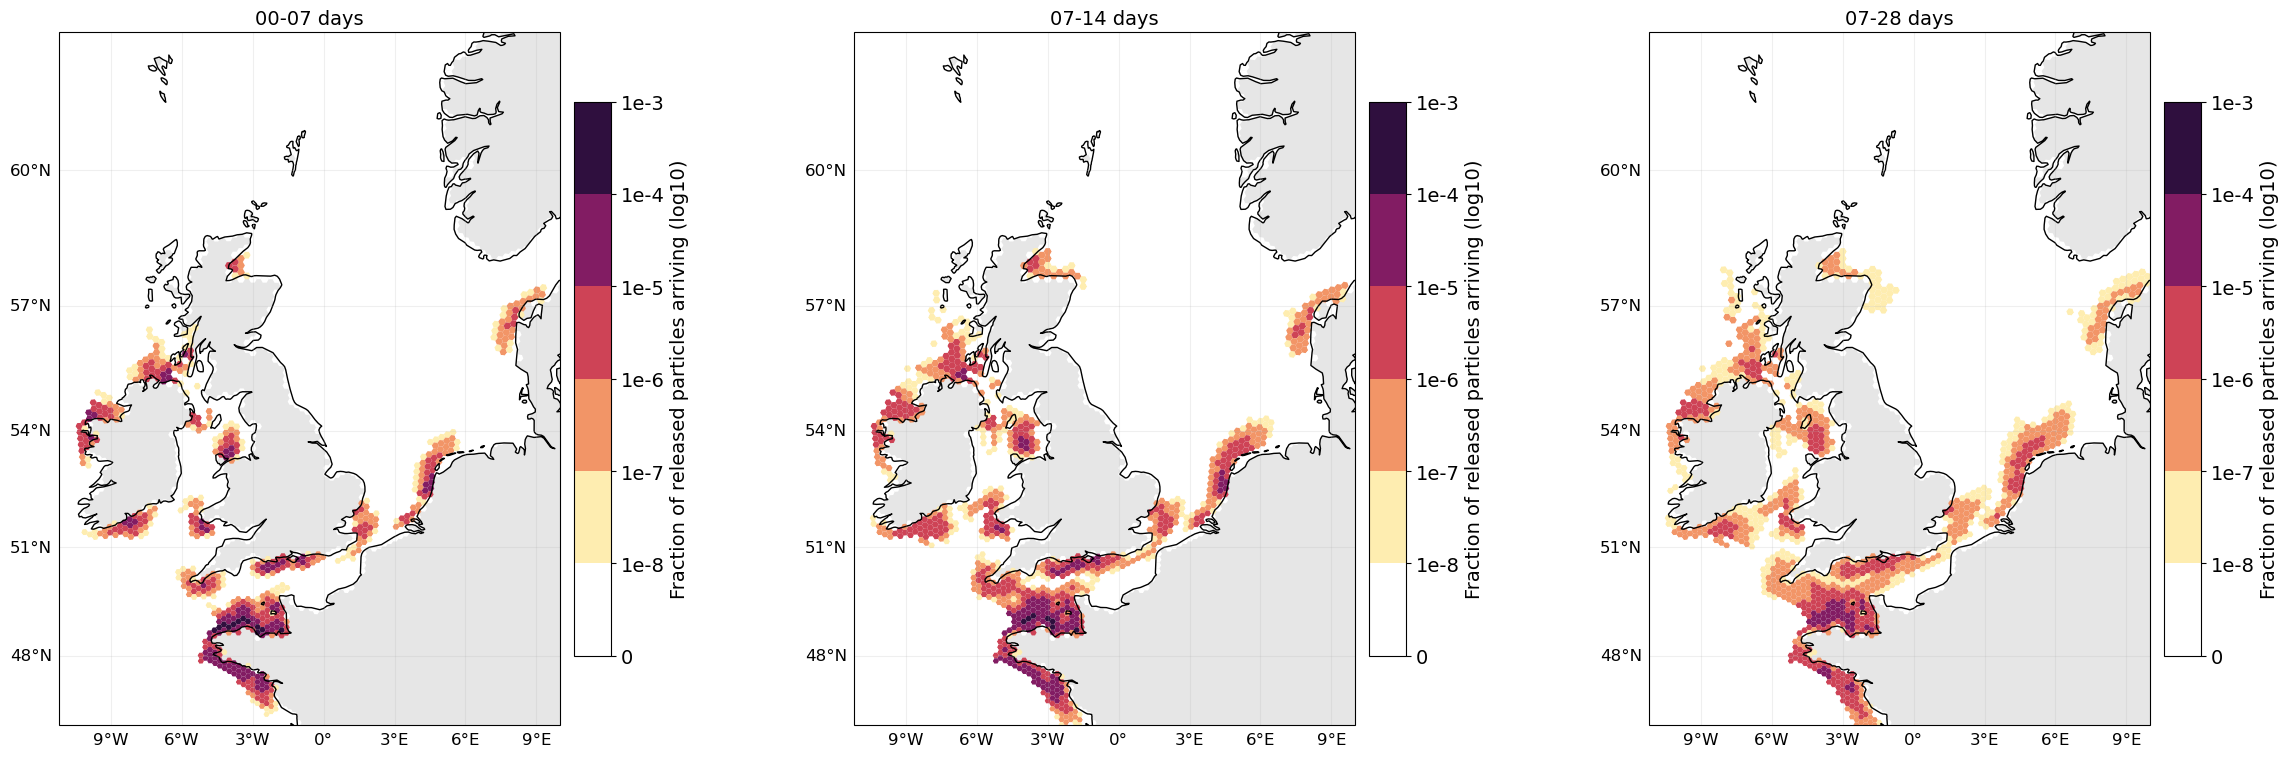

In [17]:
import matplotlib.ticker as ticker
import cartopy.feature as cfeature

def plot_fraction_arrived(ds_conn, title, timesteps, ax):
    # 1. Build hex patches for plotting
    hex_patches = []
    for _lon, _lat in zip(ds_conn.lon_hex1_corners.data.T, ds_conn.lat_hex1_corners.data.T):
        ll = np.stack((_lon, _lat)).T
        hex_patches.append(Polygon(ll, closed=False))

    # 2. Subset: only dss to habitable connections
    dss_to_habitable = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0).compute(), drop=True
    ).where(ds_conn.habitable_hex1 > 0)

    # 3. Sum over all sources, months, years for each destination (hex1)
    Nobsh = dss_to_habitable.sum(dim=["hex0", "year", "month"])

    # 4. Calculate total number of particles released from all DSS sources
    N = ds_conn.obs_per_origin_area.where(
        (ds_conn.dss_count_hex0 > 0), drop=True
    ).sum().item()

    # 5. Calculate absolute fraction for each hex1
    fraction_arrived = Nobsh / (N * timesteps)

    # 6. Prepare array for plotting (log10, -9 for zeros)
    fraction_arrived_log = np.full(len(hex_patches), -9.0)
    hex1_indices = ds_conn.hex1.values if hasattr(ds_conn, "hex1") else np.arange(len(hex_patches))
    for i, hex1 in enumerate(hex1_indices):
        val = fraction_arrived.sel(hex1=hex1).item() if hex1 in fraction_arrived.hex1 else 0
        fraction_arrived_log[i] = np.log10(val) if val > 0 else -9

    # 7. Plot
    levels = [-9, -8, -7, -6, -5, -4, -3]
    colors = ['#ffffff', '#feedb0', '#f29567', '#ce4356', '#821c63', '#2f0f3e']
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(levels, cmap.N)

    p = PatchCollection(
        hex_patches, cmap=cmap, norm=norm, alpha=1.0, linewidth=0.1,
        transform=ccrs.PlateCarree(), zorder=0
    )
    p.set_array(fraction_arrived_log)
    ax.add_collection(p, autolim=True)

    # Land color
    ax.add_feature(cfeature.LAND, facecolor='#e6e6e6', zorder=-1)

    # Coastlines
    ax.coastlines(color='black' , zorder=0)

    # Extent
    ax.set_extent([-11.2, 10, 46, 62.5])

    # Gridlines
    gl = ax.gridlines(draw_labels=True, zorder=0, alpha=0.2)
    gl.xlocator = ticker.MultipleLocator(3)
    gl.ylocator = ticker.MultipleLocator(3)
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    gl.top_labels = False
    gl.right_labels = False

    # Colorbar
    cbar = plt.colorbar(p, ax=ax, orientation='vertical', pad=0.02, shrink=0.8, aspect=15)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Fraction of released particles arriving (log10)', fontsize=14)
    cbar.set_ticks(levels)
    cbar.set_ticklabels(['0','1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3'])

    ax.set_title(title, fontsize=14)

# --- Automated plotting for all three timespans ---
fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Mercator()}, figsize=(24, 8))

plot_fraction_arrived(ds_conn_07, "00-07 days", timesteps=168, ax=axes[0])
plot_fraction_arrived(ds_conn_14, "07-14 days", timesteps=168, ax=axes[1])
plot_fraction_arrived(ds_conn_28, "07-28 days", timesteps=504, ax=axes[2]) 

#fig.suptitle("Fraction of released particles arriving at habitable hexes (DSS to habitable)", fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [18]:
dss_to_habitable_01y_14 = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.dss_count_hex0 > 0).compute(),
    drop=True,
).where(
    (ds_conn_14.habitable_hex1 > 0)
)

dss_to_habitable_01y_14

<xarray.DataArray 'obs_per_origin_area' (month: 5, year: 4, hex0: 66, hex1: 8397)> Size: 89MB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * hex0       (hex0) <U14 4kB '(-1, -36, 37)' ... '(6, -40, 34)'
  * hex1       (hex1) <U14 470kB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year       (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 528B -3.204 -3.2 -3.199 ... -1.983 -1.762 -1.778
    lon_hex1   (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex0   (hex0) float64 528B 48.82 47.72 47.57 51.68 ... 48.66 49.35 48.73
    lat_hex1   (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 4kB '(-1, -36, 37)' ... '(6, -40, 34)'

In [19]:
%%time

hex_patches = []
for _lon, _lat in zip(
    ds_conn_14.lon_hex1_corners.data.T,
    ds_conn_14.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

CPU times: user 186 ms, sys: 59.2 ms, total: 246 ms
Wall time: 181 ms


In [20]:
#calculate relative concentration
heat_map = dss_to_habitable_01y_14.sum(["hex0", "year", "month"]).sum() #sum over

relative_concentration = dss_to_habitable_01y_14.sum(["hex0", "year", "month"]).where(
    dss_to_habitable_01y_14.sum(["hex0", "year", "month"]) > 0) / heat_map
relative_concentration

<xarray.DataArray 'obs_per_origin_area' (hex1: 8397)> Size: 67kB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * hex1      (hex1) <U14 470kB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1  (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex1  (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58

In [21]:
relative_concentration.to_netcdf("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/040.1_connectivity_analysis_05m/040.1_connectivity_analysis_05_07-14days.nc")

In [22]:
rel_concentration_log = np.log10(relative_concentration)
rel_concentration_log

<xarray.DataArray 'obs_per_origin_area' (hex1: 8397)> Size: 67kB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * hex1      (hex1) <U14 470kB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1  (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex1  (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58

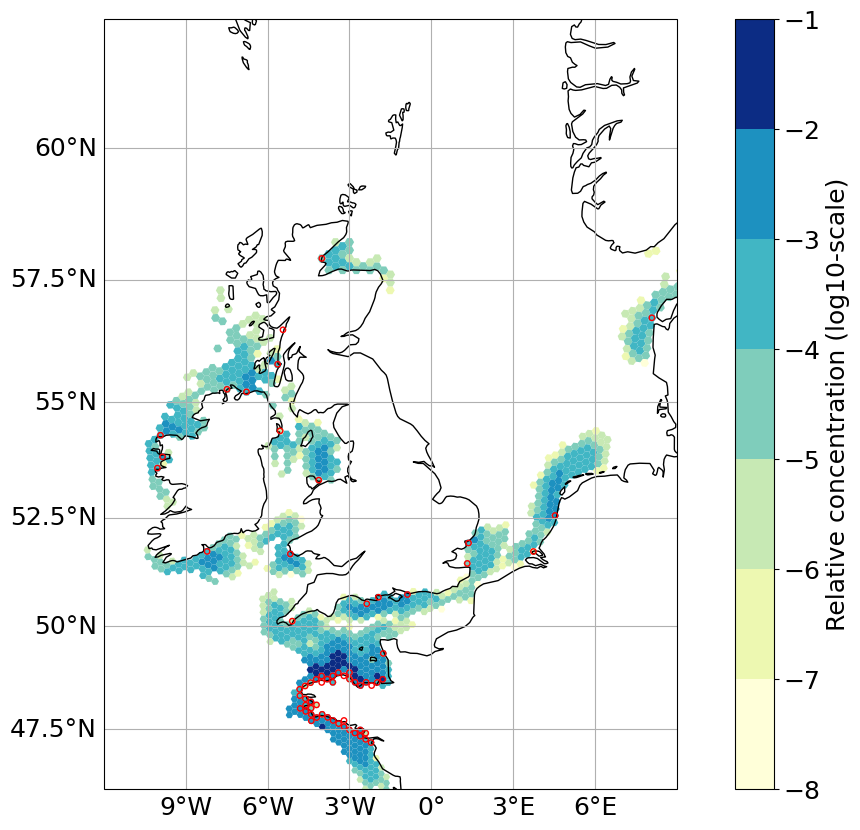

CPU times: user 3.44 s, sys: 637 ms, total: 4.08 s
Wall time: 4.81 s


In [23]:
%%time

levels = [-8, -7, -6, -5, -4, -3, -2, -1]

hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]

cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))

norm = BoundaryNorm(levels, cmap.N)

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    norm=norm,
    alpha=1.0,  
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

p.set_array(rel_concentration_log)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=18) 
cbar.set_label('Relative concentration (log10-scale)', fontsize=18)

ax.scatter(
    dss_to_habitable_01y_14.lon_hex0, dss_to_habitable_01y_14.lat_hex0,
    s=15, 
    facecolors='none',
    edgecolors="red",
    linewidth=1,
    transform=cartopy.crs.PlateCarree()
)

ax.set_extent([-12, 9, 46, 62])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

plt.show()

#ax.set_title("Any known disease site to any habitat, typical year", fontsize=16);
fig.tight_layout()
fig.savefig("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/notebooks/manuscript/05m/plots/040_connectivity_analysis_dss_habitable_1y_relconc_05m_07-14.pdf")

### 1 Year: Disease to habitable AVERAGE 07-28

In [27]:
dss_to_habitable_01y_28 = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0).compute(),
    drop=True,
).where(
    (ds_conn_28.habitable_hex1 > 0)
)

dss_to_habitable_01y_28

<xarray.DataArray 'obs_per_origin_area' (month: 4, year: 4, hex0: 66, hex1: 8397)> Size: 71MB
array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
...
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * hex0       (hex0) <U14 4kB '(-1, -36, 37)' ... '(6, -40, 34)'
  * hex1       (hex1) <U14 470kB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
  * month      (month) float64 32B 0.0 1.0 2.0 3.0
  * year       (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0   (hex0) float64 528B -3.204 -3.2 -3.199 ... -1.983 -1.762 -1.778
    lon_hex1   (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex0   (hex0) float64 528B 48.82 47.72 47.57 51.68 ... 48.66 49.35 48.73
    lat_hex1   (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 4kB '(-1, -36, 37)' ... '(6, -40, 34)'

In [28]:
%%time

hex_patches = []
for _lon, _lat in zip(
    ds_conn_28.lon_hex1_corners.data.T,
    ds_conn_28.lat_hex1_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

CPU times: user 249 ms, sys: 1.89 ms, total: 251 ms
Wall time: 250 ms


In [29]:
#calculate relative concentration
heat_map = dss_to_habitable_01y_28.sum(["hex0", "year", "month"]).sum() #sum over

relative_concentration = dss_to_habitable_01y_28.sum(["hex0", "year", "month"]).where(
    dss_to_habitable_01y_28.sum(["hex0", "year", "month"]) > 0) / heat_map

In [30]:
relative_concentration.to_netcdf("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/040.1_connectivity_analysis_05m/040.1_connectivity_analysis_05_07-28days.nc")

In [31]:
rel_concentration_log = np.log10(relative_concentration)
rel_concentration_log

<xarray.DataArray 'obs_per_origin_area' (hex1: 8397)> Size: 67kB
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * hex1      (hex1) <U14 470kB '(-1, -19, 20)' '(-1, -2, 3)' ... '(9, 9, -18)'
    lon_hex1  (hex1) float64 67kB -3.216 -3.229 -3.215 ... -0.8121 -0.8032
    lat_hex1  (hex1) float64 67kB 51.46 54.11 51.31 51.15 ... 56.27 56.43 56.58

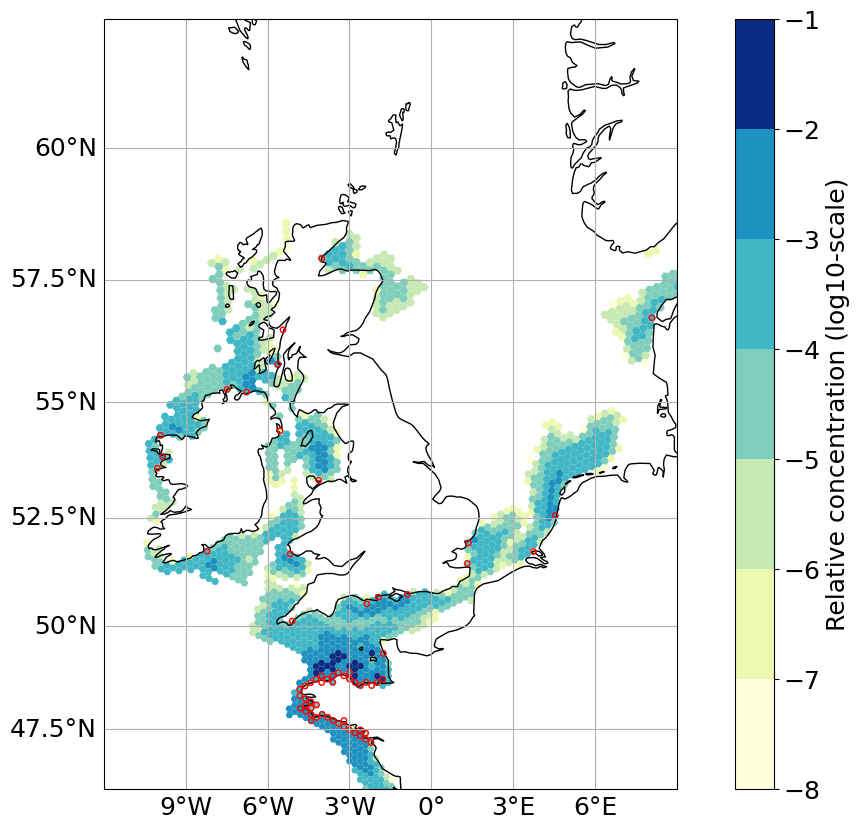

In [32]:
levels = [-8, -7, -6, -5, -4, -3, -2, -1]

hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]

cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))

norm = BoundaryNorm(levels, cmap.N)

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(12, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    norm=norm,
    alpha=1.0,  
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

p.set_array(rel_concentration_log)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=18) 
cbar.set_label('Relative concentration (log10-scale)', fontsize=18)

ax.scatter(
    dss_to_habitable_01y_28.lon_hex0, dss_to_habitable_01y_28.lat_hex0,
    s=15, 
    facecolors='none',
    edgecolors="red",
    linewidth=1,
    transform=cartopy.crs.PlateCarree()
)

ax.set_extent([-12, 9, 46, 62])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

plt.show()
fig.tight_layout()
fig.savefig("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/notebooks/manuscript/05m/plots/040_connectivity_analysis_dss_habitable_1y_relconc_05m_07-28.pdf")